In [ ]:
# Part 1 of presentation for Kariera IT conference in Wrocław, Poland (06-10-2018).
# Copyright: Szymon Moliński, Data Lions

In [1]:
%matplotlib inline
import os

import numpy as np
import rasterio as rio

from sklearn.cluster import KMeans
from skimage.exposure import equalize_adapthist

import matplotlib.pyplot as plt

In [2]:
def read_landsat_images(folder_name):
    """Function returns dictionary with pairs BAND NUMBER: filepath
    return: {band_number: filepath}"""
    file_list = os.listdir(folder_name)
    channel_list = []
    for f in file_list:
        if (f.startswith('LC') and f.endswith('.tif')):
            if 'band' in f:
                channel_list.append(folder_name + f)             
    channel_list.sort()
    channel_numbers = np.arange(1, 8)
    bands_dictionary = dict(zip(channel_numbers, channel_list))
    return bands_dictionary

# Test
satellite_images = read_landsat_images('LC081900222017052801T1-SC20180614120413/')
for band in satellite_images:
    print(band, satellite_images[band])

1 LC081900222017052801T1-SC20180614120413/LC08_L1TP_190022_20170528_20170615_01_T1_sr_band1.tif
2 LC081900222017052801T1-SC20180614120413/LC08_L1TP_190022_20170528_20170615_01_T1_sr_band2.tif
3 LC081900222017052801T1-SC20180614120413/LC08_L1TP_190022_20170528_20170615_01_T1_sr_band3.tif
4 LC081900222017052801T1-SC20180614120413/LC08_L1TP_190022_20170528_20170615_01_T1_sr_band4.tif
5 LC081900222017052801T1-SC20180614120413/LC08_L1TP_190022_20170528_20170615_01_T1_sr_band5.tif
6 LC081900222017052801T1-SC20180614120413/LC08_L1TP_190022_20170528_20170615_01_T1_sr_band6.tif
7 LC081900222017052801T1-SC20180614120413/LC08_L1TP_190022_20170528_20170615_01_T1_sr_band7.tif


In [3]:
def get_band(file, parts):
    with rio.open(file, 'r') as dataset:
        band = dataset.read(1)
    bs = band.shape
    y0 = int(bs[0] * parts[0])
    y1 = int(bs[0] * parts[1])
    x0 = int(bs[1] * parts[2])
    x1 = int(bs[1] * parts[3])
    return band[y0:y1, x0:x1]

In [4]:
rgb = {'R': get_band(satellite_images[4], (0, 1, 0, 1)),
      'G': get_band(satellite_images[3], (0, 1, 0, 1)),
      'B': get_band(satellite_images[2], (0, 1, 0, 1))}

rgb_image_may = np.dstack((rgb['R'], rgb['G'], rgb['B']))
rgb_image_may.shape

(8211, 8131, 3)

In [5]:
def show_image(image, equalize=True, level2=True):
    number_of_channels = image.shape[-1]
    
    # Normalization of Landsat 8 level 2 product
    if level2:
        image = image.astype(float)
        image = image / 10000
        image[image < 0] = 0
        image[image > 1.0] = 1.0

    # Equalization - optional
    if equalize:
        for i in range(number_of_channels):
            image[:, :, i] = equalize_adapthist(image[:, :, i], clip_limit=0.02)
            
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

/home/datalions/miniconda3/envs/l8p/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


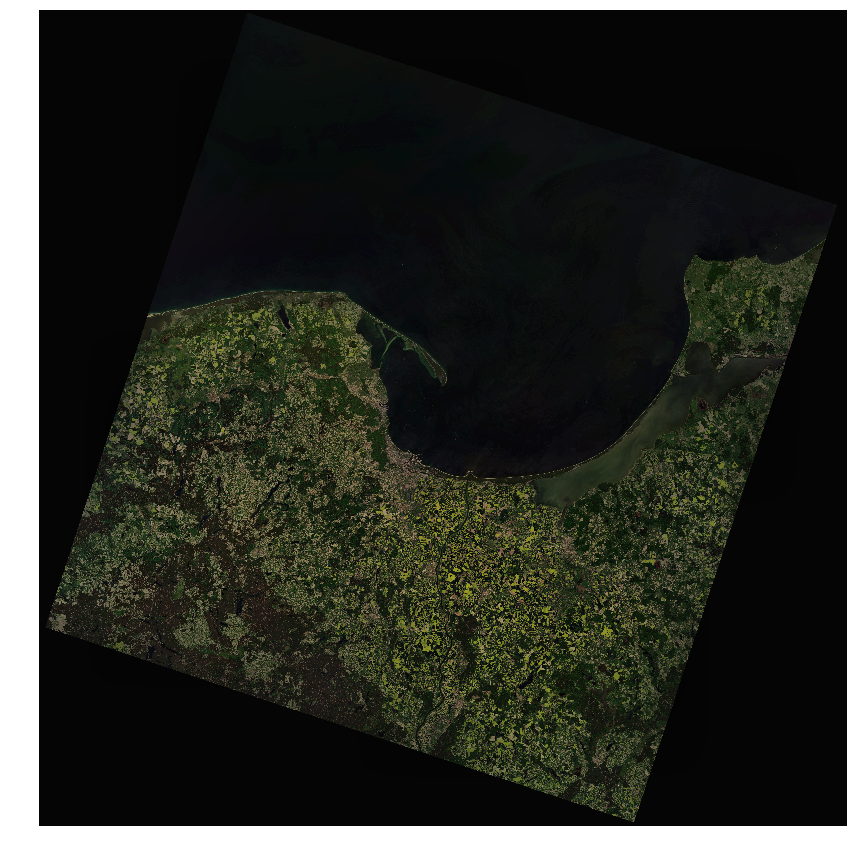

In [6]:
show_image(rgb_image_may, True)

In [7]:
def equalize_and_save(image, image_name):
    number_of_channels = image.shape[-1]
    image = image.astype(float)
    image = image / 10000
    
    # Normalization
    image[image < 0] = 0
    image[image > 1.0] = 1.0

    # Equalization - optional
    for i in range(number_of_channels):
        image[:, :, i] = equalize_adapthist(image[:, :, i], clip_limit=0.03)
    plt.imsave(image_name, image)
    print('Image saved successfully')
    return 0
    

In [8]:
# Line below saves rgb image
# equalize_and_save(rgb_image_may, 'algal_blooms_170528.jpg')

In [9]:
# Data normalization

def normalize(raster):
    samples = raster.astype(float)
    samples = (samples / 10000) * 255
    samples[samples < 0] = 0
    samples[samples > 255] = 255
    samples = samples.astype(np.uint8)
    return samples

In [10]:
# Image quantization

def group_pixels(raster, n_colors=4):
    width, height, depth = raster.shape
    reshaped_raster = raster.reshape(width * height, depth)
    model = KMeans(n_clusters=n_colors, n_jobs=-1, random_state=0)
    labels = model.fit_predict(reshaped_raster)
    quantized_raster = np.reshape(labels, (width, height))
    return quantized_raster, model

/home/datalions/miniconda3/envs/l8p/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


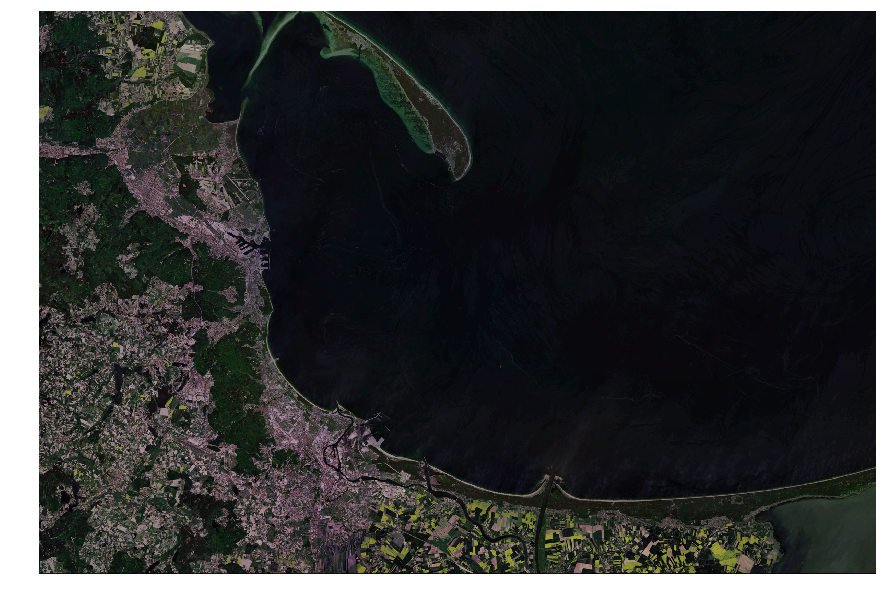

In [11]:
cutbox = (0.4, 0.6, 0.35, 0.65)
rgb = {'R': get_band(satellite_images[4], cutbox),
      'G': get_band(satellite_images[3], cutbox),
      'B': get_band(satellite_images[2], cutbox)}

rgb_image_may_small = np.dstack((rgb['R'], rgb['G'], rgb['B']))
show_image(rgb_image_may_small)

In [12]:
number_of_samples = 4
normalized_image = normalize(rgb_image_may_small)
quantized_data = group_pixels(normalized_image, number_of_samples) # returns data as well model: [data, model]

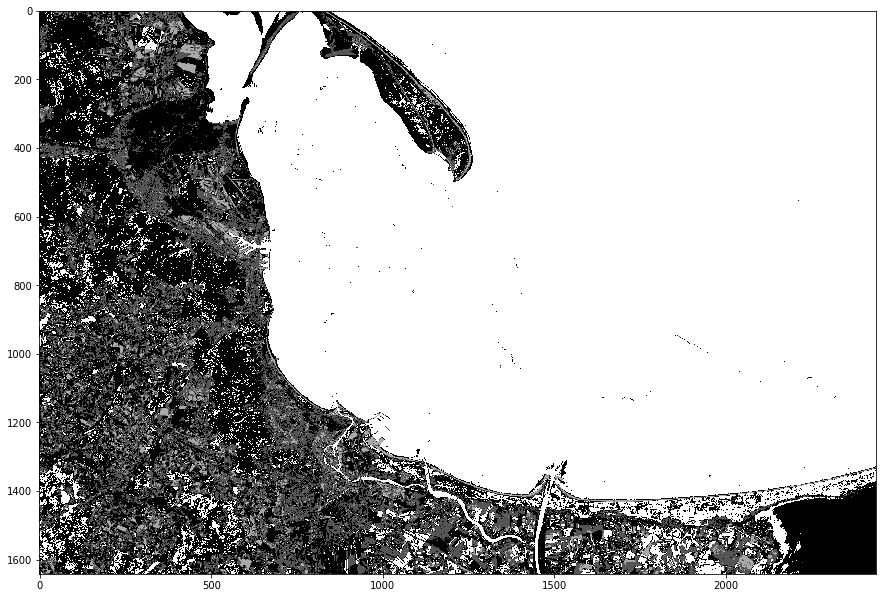

In [13]:
output_labels = quantized_data[0]

plt.figure(figsize=(15, 15))
plt.imshow(output_labels, cmap='gray')
plt.show()

In [14]:
cutbox = (0.4, 0.6, 0.35, 0.65)

bands_list = np.dstack([get_band(satellite_images[x], cutbox) for x in satellite_images])

In [15]:
number_of_samples = 4
normalized_image = normalize(bands_list)
quantized_data = group_pixels(normalized_image, number_of_samples) # returns data as well model: [data, model]

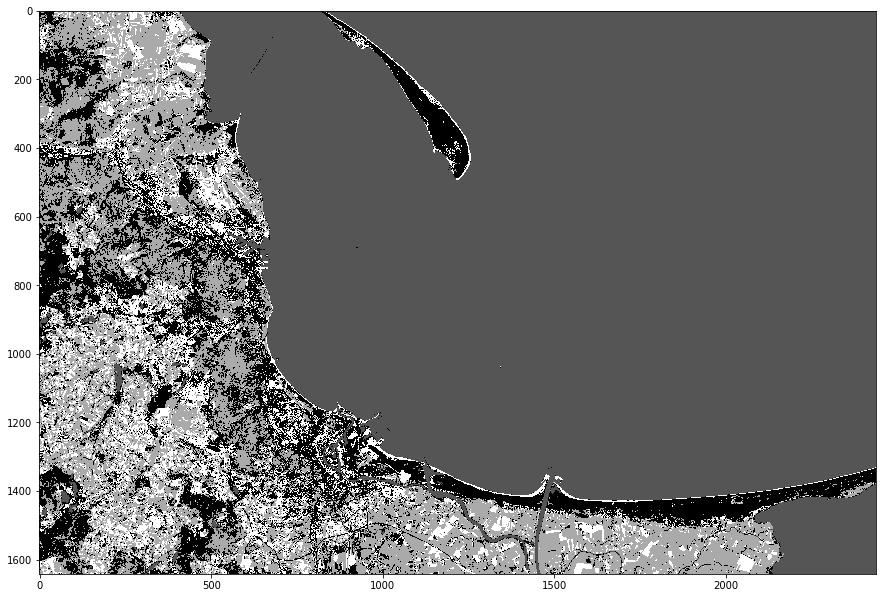

In [16]:
output_labels = quantized_data[0]

plt.figure(figsize=(15, 15))
plt.imshow(output_labels, cmap='gray')
plt.savefig('classified_may.jpg', dpi=600)
plt.show()


/home/datalions/miniconda3/envs/l8p/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


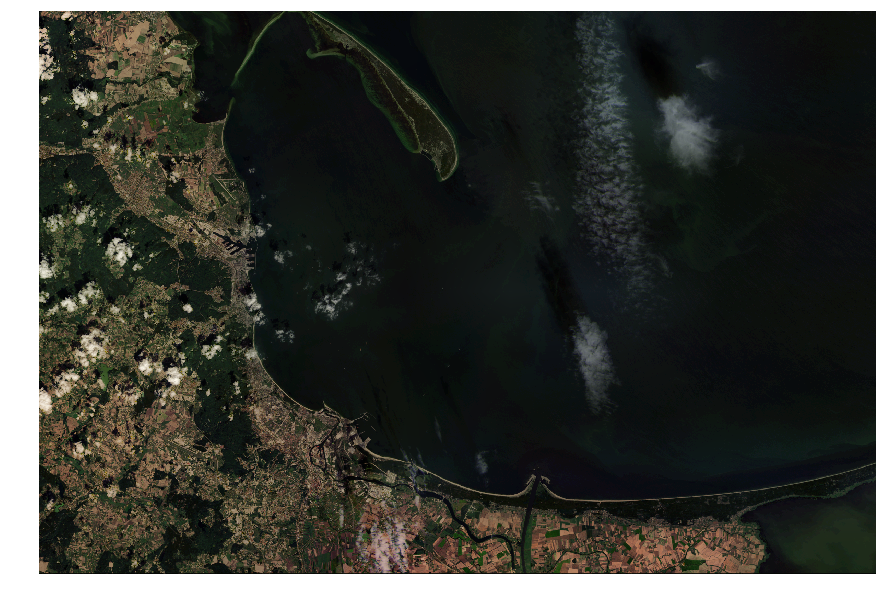

In [17]:
new_scene = read_landsat_images('LC081900222018080301RT-SC20180807172951/')

cutbox = (0.4, 0.6, 0.35, 0.65)
rgb = {'R': get_band(new_scene[4], cutbox),
      'G': get_band(new_scene[3], cutbox),
      'B': get_band(new_scene[2], cutbox)}
rgb_image_august_small = np.dstack((rgb['R'], rgb['G'], rgb['B']))
show_image(rgb_image_august_small)

In [18]:
# Cloud remove

class PixelQA:
    """Class removes clouds and cloud shadows from images based on the quality band given with Landsat's scene.
    Class is initialized with the folder with all Landsat scenes and the QA band.
    
    Class methods:
    prepare values(clear_key='all') - method prepares values to remove with accordance to the Landsat documentation:
    https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment.
    clear_pixels(band, qa_input = None, clear_by='all', nofill_value=0.0) - method clears pixels of a given band.
    Method takes band for cleaning (band) multiply it with (qa_input) where all values to remove are zeros and
    other values are ones. Removed pixels are filled by nofill_value."""
    
    
    def __init__(self, data_folder):
        
        # prepare qa file address
        file_list = os.listdir(data_folder)
        for f in file_list:
            if (f.startswith('LC') and f.endswith('pixel_qa.tif')):
                self.bqa_file = data_folder + f
        
        # prepare qa band
        with rio.open(self.bqa_file) as f:
            self.qa_band = f.read(1)
            
        # Dictionary with cloud pixel values for pixel_qa band 
        # (https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment)
        self.clouds = {'Cloud Shadow': [328, 392, 840, 904, 1350],
                      'Cloud': [352, 368, 416, 432, 480, 864, 880, 928, 944, 992],
                      'Cloud confidence': {'Low': [322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880],
                                           'Medium': [386, 388, 392, 400, 416, 432, 900, 904, 928, 944],
                                           'High': [480, 992]},
                      'Cirrus confidence': {'Low': [322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480],
                                           'High': [834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992]}}
        
    def prepare_values(self, clear_key):
        """
        Function prepares values to remove (cloud pixels) based on the input.
        input 1: clear_key (string)
        parameters:
        'all' - returns values for Clouds and Cloud Shadows,
        'Cloud Shadow' - returns values for Cloud Shadows,
        'Cloud' - returns values for Clouds,
        'Cloud low' - returns pixel values which could be a cloud with low, medium and high probability,
        'Cloud medium' - returns pixel values which could be a cloud with medium and high probability,
        'Cloud high' - returns pixel values which could be a cloud with high probability,
        'Cirrus low' - returns pixel values which could be a cirrus with low and high probability,
        'Cirrus high' - returns pixel values which could be a cirrus with high probability.
        output: python list with pixel values to remove from the scene"""
        
        values = {'all': [self.clouds['Cloud Shadow'], self.clouds['Cloud']],
                 'Cloud Shadow': [self.clouds['Cloud Shadow']],
                 'Cloud': [self.clouds['Cloud']],
                 'Cloud low': [self.clouds['Cloud confidence']['Low'],
                               self.clouds['Cloud confidence']['Medium'],
                               self.clouds['Cloud confidence']['High']],
                 'Cloud medium': [self.clouds['Cloud confidence']['Medium'],
                                  self.clouds['Cloud confidence']['High']],
                 'Cloud high': [self.clouds['Cloud confidence']['High']],
                 'Cirrus low': [self.clouds['Cirrus confidence']['Low'],
                                self.clouds['Cirrus confidence']['High']],
                 'Cirrus high': [self.clouds['Cirrus confidence']['High']]}
        values_to_remove = values[clear_key]
        
        if len(values_to_remove) > 1:
            vals = []
            for values_list in values_to_remove:
                vals = vals + values_list
        else:
            vals = values_to_remove[0]
        return vals
    
    def clear_pixels(self, band, qa_input = None, clear_by='all', nofill_value=0.0):
        """
        Function removes cloud pixels from the chosen scene based on the scene quality band.
        input 1: band (numpy array) - band for the cloud removal.
        input 2: qa_input - if None then self.qa_band is used as the mask for cloud pixels. Else mask should be
        given as a numpy array.
        input 3: clear_all - parameter to obtain values of cloud pixels:
        'all' - returns values for Clouds and Cloud Shadows,
        'Cloud Shadow' - returns values for Cloud Shadows,
        'Cloud' - returns values for Clouds,
        'Cloud low' - returns pixel values which could be a cloud with low, medium and high probability,
        'Cloud medium' - returns pixel values which could be a cloud with medium and high probability,
        'Cloud high' - returns pixel values which could be a cloud with high probability,
        'Cirrus low' - returns pixel values which could be a cirrus with low and high probability,
        'Cirrus high' - returns pixel values which could be a cirrus with high probability.
        input 4: nofill_value - value which replaces cloud pixels.
        output: numpy array (scene) without cloud pixels."""
        
        values_to_remove = self.prepare_values(clear_by)
        if qa_input is None:
            qa_channel = self.qa_band
        else:
            qa_channel = qa_input
        for val in values_to_remove:
            qa_channel[qa_channel==val] = nofill_value
        qa_channel[qa_channel > 0] = 1
        output_band = band * qa_channel
        return output_band

/home/datalions/miniconda3/envs/l8p/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


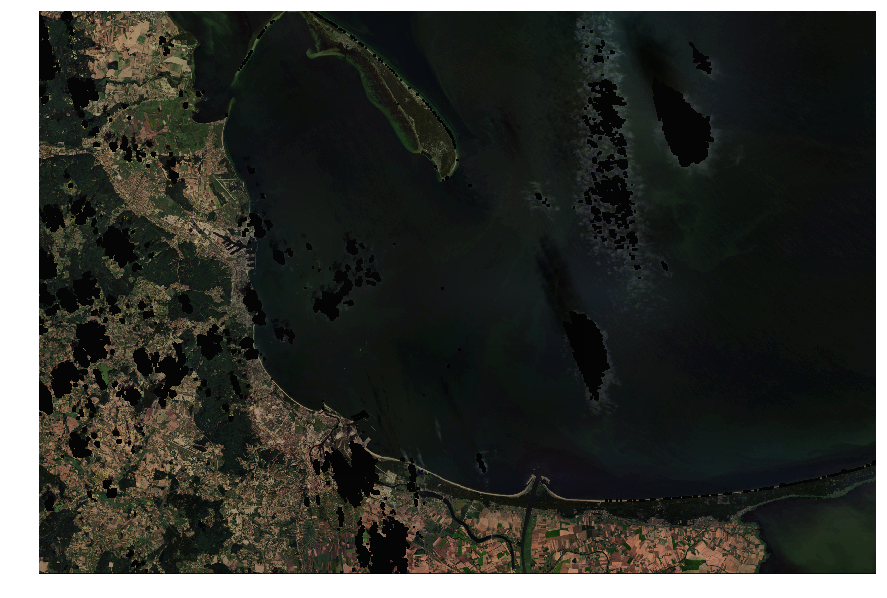

In [19]:
# Initialize qa band
qa_address = 'LC081900222018080301RT-SC20180807172951/'
qa_band = PixelQA(qa_address)

# Clip to area-of-interest
qa_band.qa_band = get_band(qa_band.bqa_file, cutbox)

# Read data and delete cloud pixels from base image
new_scene = read_landsat_images(qa_address)
cutbox = (0.4, 0.6, 0.35, 0.65)
rgb = {'R': qa_band.clear_pixels(get_band(new_scene[4], cutbox)),
      'G': qa_band.clear_pixels(get_band(new_scene[3], cutbox)),
      'B': qa_band.clear_pixels(get_band(new_scene[2], cutbox))}

rgb_image_august_clouds = np.dstack((rgb['R'], rgb['G'], rgb['B']))
show_image(rgb_image_august_clouds)

In [20]:
bands_list_august = np.dstack([qa_band.clear_pixels(get_band(new_scene[x], cutbox)) for x in new_scene])

In [21]:
# It's important to do something with the missing values (clouds) in the image.
# I copy values from the first scene into the second scene instead of cloud pixels

bands_list_august[bands_list_august == 0] = bands_list[bands_list_august == 0]

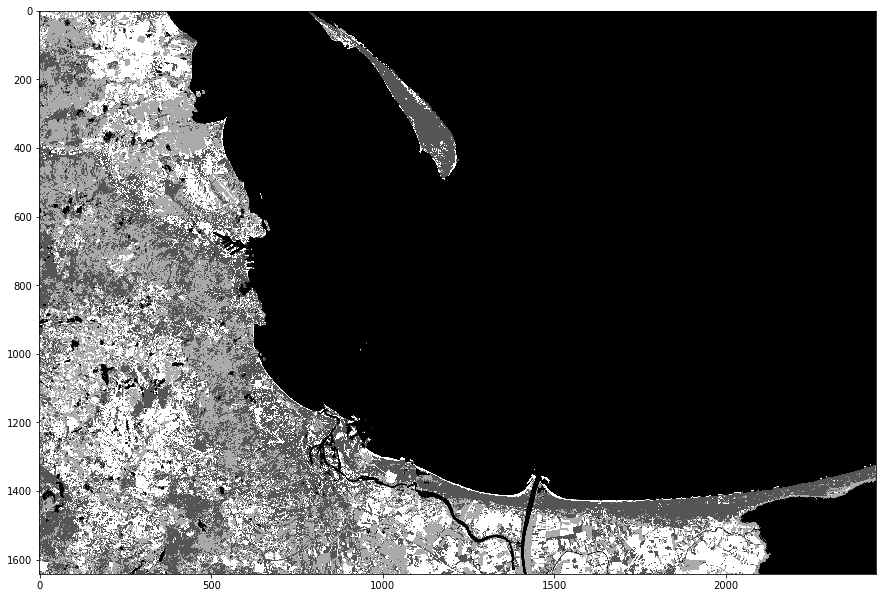

In [22]:
number_of_samples = 4

normalized_image = normalize(bands_list_august)

quantized_data_august = group_pixels(normalized_image, n_colors=number_of_samples) 

output_labels_august = quantized_data_august[0]

plt.figure(figsize=(15, 15))
plt.imshow(output_labels_august, cmap='gray')
plt.savefig('classified_august_base_may.jpg', dpi=600)
plt.show()

In [23]:
def equalize(image):
    number_of_channels = image.shape[-1]
    image = image.astype(float)
    image = image / 10000
    image[image < 0] = 0
    image[image > 1.0] = 1.0

    for i in range(number_of_channels):
        image[:, :, i] = equalize_adapthist(image[:, :, i], clip_limit=0.02)
    return image

def save_compared(images, filename):
    ncol = 2
    
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(wspace=0.02)
    img_no = 1
    for i in range(ncol):
        im = images[i]
        ax = plt.subplot(1, ncol, img_no)
        img_no = img_no + 1
        if i < 1:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)
        ax.axis('off')
    plt.savefig(filename, dpi=600)
    plt.show()

images_may = [output_labels, equalize(rgb_image_may_small)]
images_august = [output_labels_august, equalize(rgb_image_august_clouds)]

/home/datalions/miniconda3/envs/l8p/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


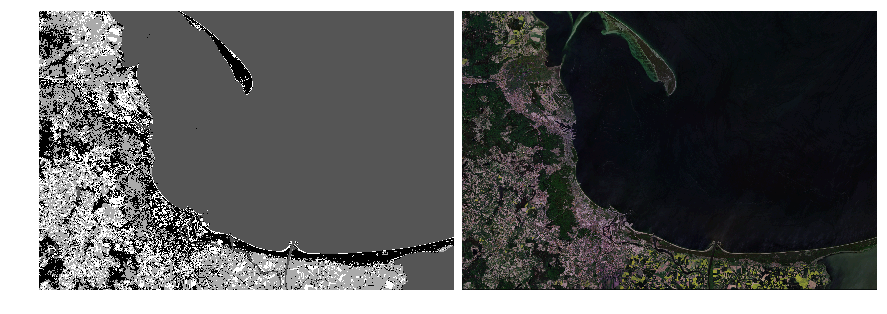

In [24]:
save_compared(images_may, 'comparison_may_scene.jpg')

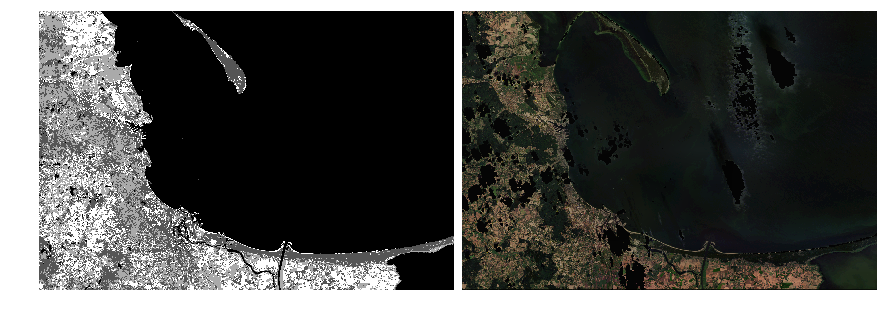

In [25]:
save_compared(images_august, 'comparison_august_scene.jpg')